## Loading Files

In [1]:
import pandas as pd
from sklearn.metrics import classification_report
import scipy.sparse as sparse

In [2]:
!pip install memory-profiler

You should consider upgrading via the '/Users/ryan/Documents/Ryan/projet Prim/tst/env/bin/python3 -m pip install --upgrade pip' command.


In [3]:
%load_ext memory_profiler

In [4]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
# -- Adapt it with the id of your files
userfile_id = '1SujkUIqpPKg9LlJ8s77upbeTKkenmrLc'
adjency_id = '1Oz8rbp1HOb9EB_7dZYLQdVJ09oAyMlWB'

In [6]:
# -- some cleaning
needed = True
if needed :
  %rm -R gpeg/
  %rm context.py
  %rm fastGraph.py
  %rm node.py
  %rm _recSystems.py
  %rm trivialClf.py
  %rm edge.py
  %rm main.py 
  %rm scorer.py

rm: cannot remove 'context.py': No such file or directory
rm: cannot remove 'fastGraph.py': No such file or directory
rm: cannot remove 'node.py': No such file or directory
rm: cannot remove '_recSystems.py': No such file or directory
rm: cannot remove 'trivialClf.py': No such file or directory
rm: cannot remove 'edge.py': No such file or directory
rm: cannot remove 'main.py': No such file or directory
rm: cannot remove 'scorer.py': No such file or directory


In [4]:
!git clone -b heavy https://github.com/TiphaineV/gpeg.git

Cloning into 'gpeg'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (300/300), done.
remote: Compressing objects: 100% (190/190), done.
remote: Total 466 (delta 201), reused 187 (delta 108), pack-reused 166
Receiving objects: 100% (466/466), 1.03 MiB | 2.45 MiB/s, done.
Resolving deltas: 100% (289/289), done.


In [8]:
cd gpeg/fast_implementation/

/content/gpeg/fast_implementation


In [5]:
# Modules
import numpy as np
from _recSystems import _Clf
from fastGraph import Graph
from trivialClf import TrivialClf
from scorer import ClfScorer
from features import StandardFeatures

In [15]:
adjencyBool = False
userData = False

In [ ]:
# -- Loading userData (heavy, takes around a minute)
if userData:
    downloaded = drive.CreateFile({'id':userfile_id}) 
    downloaded.GetContentFile('userData.csv')
    userDataStream = pd.read_csv('userData.csv', chunksize= 1e6) # please don't change chuksize

In [ ]:
# -- Loading adjency 
if adjencyBool:
    downloaded = drive.CreateFile({'id':adjency_id}) 
    downloaded.GetContentFile('adjency-20M.npz')

## Building Adjency Matrix

In [6]:
%%time
# -- Graph construction, nChunk * 1e6 rows are processed from movieLens 20M.
# -- Takes around 2'30 for one chunk
%memit graph = Graph(path = 'adjency-20M.npz')

Graph init ...
peak memory: 866.68 MiB, increment: 765.61 MiB
CPU times: user 1.3 s, sys: 255 ms, total: 1.56 s
Wall time: 2.09 s


## Graph split

In [7]:
%%time
# -- Parameters
alpha = 0.1 # test proportion in the split

# -- train_test_split
%memit trainEdges, testEdges = graph.train_test_split(alpha= alpha)

peak memory: 2115.49 MiB, increment: 1248.80 MiB
CPU times: user 23.1 s, sys: 664 ms, total: 23.8 s
Wall time: 24.3 s


## Classification

In [8]:
# -- Loading userData
%memit userData = pd.read_csv('userData.csv')

peak memory: 3455.93 MiB, increment: 2286.30 MiB


In [9]:
print(userData.head(10))

   Unnamed: 0  userId  movieId  rating     timestamp_rating  tag timestamp_tag
0           0       1        2     3.5  2005-04-02 23:53:47  NaN           NaN
1           1       1       29     3.5  2005-04-02 23:31:16  NaN           NaN
2           2       1       32     3.5  2005-04-02 23:33:39  NaN           NaN
3           3       1       47     3.5  2005-04-02 23:32:07  NaN           NaN
4           4       1       50     3.5  2005-04-02 23:29:40  NaN           NaN
5           5       1      112     3.5  2004-09-10 03:09:00  NaN           NaN
6           6       1      151     4.0  2004-09-10 03:08:54  NaN           NaN
7           7       1      223     4.0  2005-04-02 23:46:13  NaN           NaN
8           8       1      253     4.0  2005-04-02 23:35:40  NaN           NaN
9           9       1      260     4.0  2005-04-02 23:33:46  NaN           NaN


In [10]:
# -- Getting feature functions
featFncts = StandardFeatures.get_featFncts()

In [11]:
# -- Fitting recommender system
clf = TrivialClf(userData, graph.adjency, featFncts)
%memit clf.fit(trainEdges)

peak memory: 4656.63 MiB, increment: 2156.26 MiB


## Scoring predictions

In [12]:
# -- Prediction (quite long because linear in nb of edges)
yPred = clf.predict(testEdges)
yTrue = clf._get_labels(testEdges)

random prop 0.8839735


In [13]:
print(classification_report(yTrue, yPred))

              precision    recall  f1-score   support

           0       0.94      0.68      0.79   1878630
           1       0.06      0.32      0.10    121370

    accuracy                           0.66   2000000
   macro avg       0.50      0.50      0.44   2000000
weighted avg       0.89      0.66      0.75   2000000



In [13]:
sample = np.random.choice(range(len(yPred)), size = 10)
print(sample)

[1869840  657360 1072973  368198  319400 1666520 1580765  476532 1522539
  836864]


In [14]:
print('Predictions \n', yPred.iloc[sample].astype('uint8'))

Predictions 
 862907     0
743932     0
1214112    0
416775     0
361301     0
1883990    0
1787145    1
539791     0
1721577    0
947777     0
dtype: uint8


In [15]:
print('Ground truth labels \n', yTrue.iloc[sample])

Ground truth labels 
 1869840    0
657360     0
1072973    0
368198     0
319400     0
1666520    0
1580765    0
476532     0
1522539    0
836864     0
Name: rating, dtype: uint8


In [14]:
# -- Scoring
#scorer = ClfScorer()
#%memit score = scorer.score(clf, testEdges) 

random prop 0.8839735
              precision    recall  f1-score   support

     class 0       0.94      0.68      0.79   1878630
     class 1       0.06      0.32      0.10    121370

    accuracy                           0.66   2000000
   macro avg       0.50      0.50      0.45   2000000
weighted avg       0.89      0.66      0.75   2000000

peak memory: 3251.55 MiB, increment: 129.60 MiB


## Some Exploratory Data Analysis

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

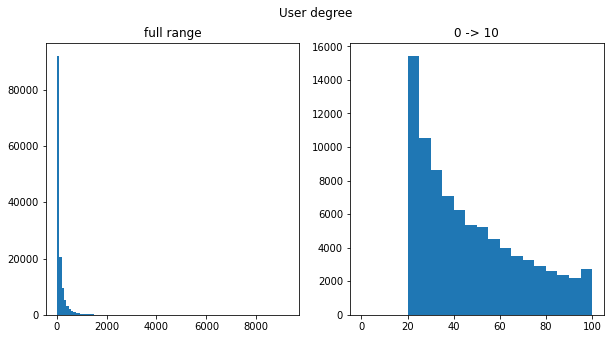

In [40]:
n = graph.rowFormat.shape[0]
degreeDist = [graph.rowFormat[i].nnz for i in range(1,n)]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('User degree')
ax1.hist(degreeDist, bins= 100)
ax1.set_title('full range')
ax2.hist(degreeDist, bins = 20, range=(0,100))
ax2.set_title('0 -> 100')
plt.show()

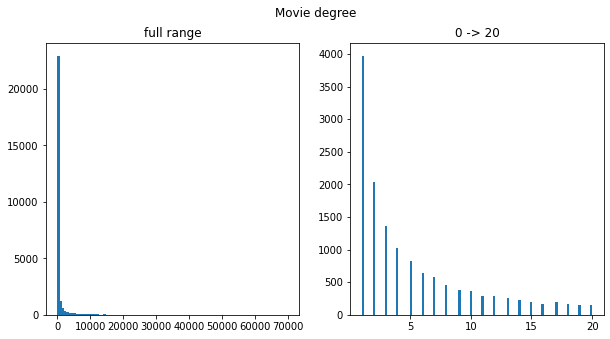

In [69]:
m = graph.colFormat.shape[1]
degreeDist = [graph.colFormat[:,i].nnz for i in range(1,m)]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Movie degree')
ax1.hist(degreeDist, bins= 100, range= (1, 70000), log=False)
ax1.set_title('full range')
ax2.hist(degreeDist, bins = 100, range=(1,20), log= False)
ax2.set_title('0 -> 20')
plt.show()

weight of the first degrees 0.6706652126499455


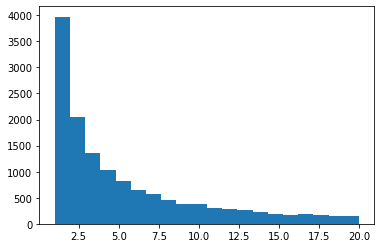

In [76]:
count = plt.hist(degreeDist, bins = 20, range=(1,20), log= False)[0]

print('weight of the first degrees', np.sum(count[[0,1,2,3,4]]) /np.sum(count))

**Remarks** : 

When predicting the class of an edge (user, movie) we assume we have gathered underlying data on the user or on the movie during the fit on the training data.
However, because a lot of movies are seen once or twice, with a non negligible probability, we might have to classify an edge for which the movie has not been seen.

**Solution** :

A way to tackle this problem is to threshold the data set by the movie degrees.